## 投資策略回測  

分成兩個部分:  
一、股票資料視覺化，畫出技術線圖考慮如何訂定策略  
二、概略比較各策略之績效，試圖找出影響股價的不變因子或相關性  


* Strategy  
> #1 定期定額  
> #2 移動平均線  
> #3 市場心理  
> #4 綜合型  

回測模型建立完成後，下一步是爬蟲抓取財經新聞進行文字探勘，並納入模型中，以期從市場心理的面向掌握股價變動。

在研究的過程中，發現一個強大的套件-[pandas_datareader](https://pandas-datareader.readthedocs.io/en/latest/remote_data.html#remote-data-iex)，所以之前的爬蟲就當是技能訓練，以下直接以此套件操作，將重點放在分析以及回測策略  

In [1]:
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import matplotlib.pyplot as plt
from pandas_datareader import data
import numpy as np

# collect data for QQQ from 2015-05-01 to 2019-04-28
symbol = 'QQQ'
start = '2015-05-01'
end = '2019-04-28'
df = data.DataReader(name='QQQ', data_source='iex', start=start, end=end)
print(df.head())
df.info()
df.to_csv("QQQdata.csv".format(symbol),na_rep='NA')

                open      high       low     close    volume
date                                                        
2015-05-01  104.0040  105.0339  103.9847  104.9665  32874307
2015-05-04  105.3034  105.7943  105.0820  105.1398  23507259
2015-05-05  104.7259  104.9184  103.3783  103.4264  47843265
2015-05-06  103.6093  103.9077  102.0259  102.7141  42687150
2015-05-07  102.6853  103.6189  102.6083  103.3302  29335806
<class 'pandas.core.frame.DataFrame'>
Index: 1004 entries, 2015-05-01 to 2019-04-26
Data columns (total 5 columns):
open      1004 non-null float64
high      1004 non-null float64
low       1004 non-null float64
close     1004 non-null float64
volume    1004 non-null int64
dtypes: float64(4), int64(1)
memory usage: 47.1+ KB


一樣先將收盤價走勢圖畫出來觀察
* 問題: 日期不知道為什麼顯示不出來，試過各種方法都沒有用，有說法是這是軟體的BUG-最後升級各種版本突然解決

In [2]:
#set plot type
plt.rcParams['figure.figsize'] = (15, 5)
font = {'family': 'Segoe Script', 'weight': 'normal', 'size': 15}
plt.rc('font',**font)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rcParams['axes.unicode_minus']=False #show minus

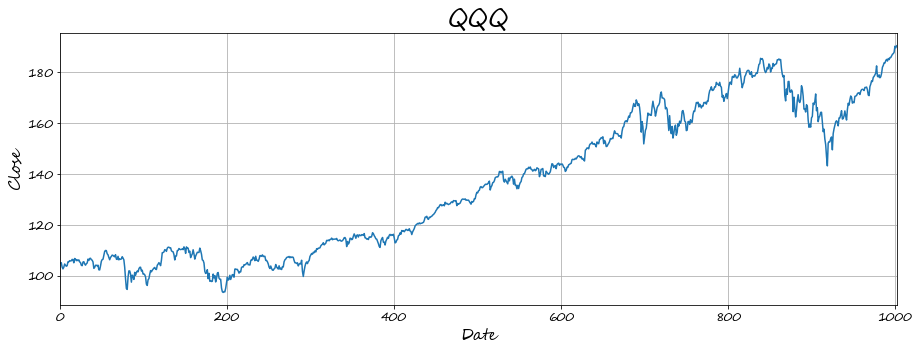

In [3]:
#plt.style.use('ggplot')
df = pd.read_csv('QQQdata.csv')
plt.title(symbol,fontsize=25)

#set label
plt.xlabel('Date',fontsize=15)
plt.ylabel('Close',fontsize=15)

plt.xticks(rotation=20)
df['close'].plot(grid = True)
plt.show()

### K線圖(candlestick)    
一般常用套件為mpl_finance(從matplotlib分出來的)(後面也會用)，以下用視覺化功能強且有互動式功能的plotly    


In [4]:
import plotly
plotly.__version__

'3.8.1'

In [5]:
import plotly 

import plotly.plotly as py
import plotly.graph_objs as go
from datetime import datetime

trace = go.Candlestick(x=df['date'],
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'])
data = [trace]
layout = {
    'title': 'QQQ Candlestick chart',
    'yaxis': {'title': 'QQQ ETF'},
}
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='QQQ_candlestick')

C:\Users\Elvish\anaconda3\envs\py35\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



#### 移動平均線(Moving Average)  
* 一段期間內價格平均值  
* 常見應用:  
> 股價突破均線時買進，跌破均線時賣出  
> 短天期均線向上穿越長天期均線時買進（黃金交叉）  
> 短天期均線向下穿越長天期均線時賣出（死亡交叉）  

In [36]:
df['close'].head()

0    104.9665
1    105.1398
2    103.4264
3    102.7141
4    103.3302
Name: close, dtype: float64

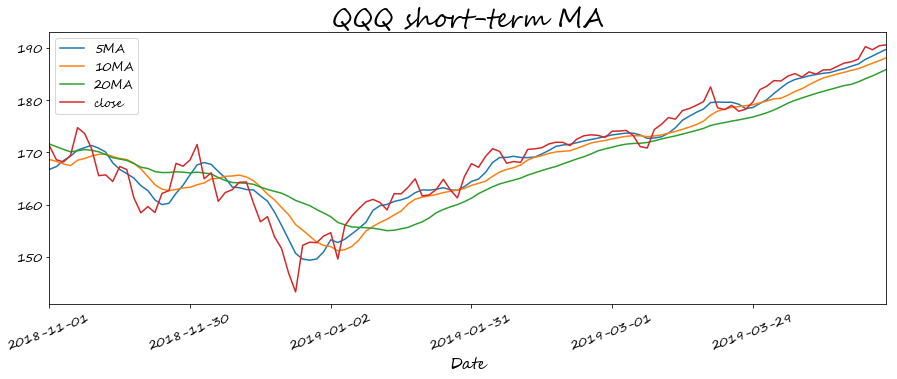

In [45]:
df = pd.read_csv('QQQdata.csv')
#short term
df['c5d'] = df['close'].rolling(5,min_periods = 1).mean()
df['c10d'] = df['close'].rolling(10,min_periods = 1).mean()
df['c20d'] = df['close'].rolling(20,min_periods = 1).mean()

#long term
df['c60d'] = df['close'].rolling(60,min_periods = 1).mean()
df['c120d'] = df['close'].rolling(120,min_periods = 1).mean()
df['c200d'] = df['close'].rolling(200,min_periods = 1).mean()

df = df.set_index(['date']) #set date as index to use .loc()

(df.loc['2018-11-01':'2019-05-01','c5d']).plot(label='5MA')
(df.loc['2018-11-01':'2019-05-01','c10d']).plot(label='10MA')
(df.loc['2018-11-01':'2019-05-01','c20d']).plot(label='20MA')

(df.loc['2018-11-01':'2019-05-01','close']).plot(label='close')

#set label, ticks,legend
plt.title(symbol+' short-term MA',fontsize=25)
plt.xlabel('Date',fontsize=15)
plt.xticks(rotation=20)

font = {'family': 'Segoe Script', 'weight': 'normal', 'size': 12}
plt.legend(prop=font)
#fontname='Hanyi Senty Diary'Goudy Old Style#from matplotlib.font_manager import fontManager#fontManager.ttflist

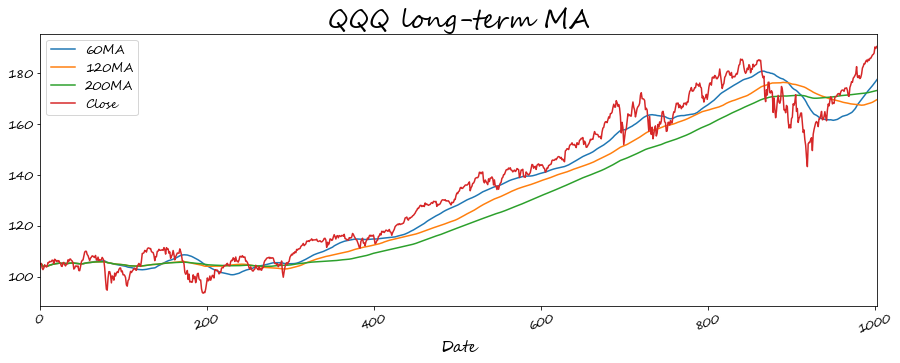

In [35]:
df['c60d'].plot(label='60MA')
df['c120d'].plot(label='120MA')
df['c200d'].plot(label='200MA')
df['close'].plot(label='Close')

#set title, label, ticks,legend
plt.title(symbol+' long-term MA',fontname='Segoe Script',fontsize=25)
plt.xlabel('Date',fontname='Segoe Script',fontsize=15)
plt.xticks(fontname='Segoe Script',fontsize=12,rotation=20)
plt.yticks(fontname='Segoe Script',fontsize=12)

font = {'family': 'Segoe Script', 'weight': 'normal', 'size': 12}
plt.legend(prop=font)

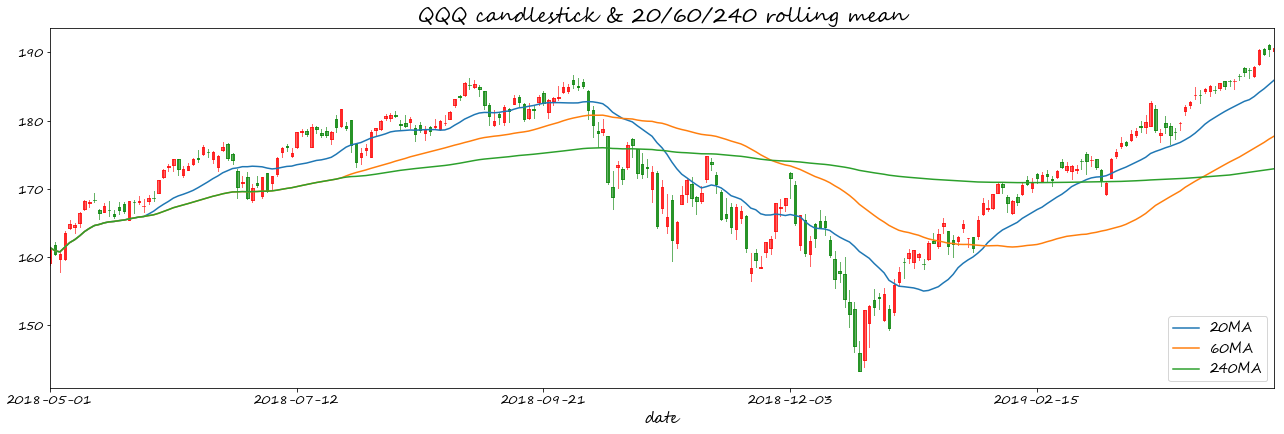

In [11]:
import mpl_finance as mpf

import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import matplotlib.pyplot as plt
from pandas_datareader import data
import numpy as np

plt.rcParams['font.sans-serif'] = ['simhei'] #set chinese word font
plt.rcParams['axes.unicode_minus']=False #show minus

# collect data for QQQ from 2017-05-01 to 2019-04-28
symbol = 'QQQ'
start = '2018-05-01'
end = '2019-04-28'
df1 = data.DataReader(name='QQQ', data_source='iex', start=start, end=end)

fig = plt.figure(figsize=(17, 10))
ax = fig.add_axes([0,0.2,1,0.5])
mpf.candlestick2_ochl(ax, df1['open'], df1['close'], df1['high'], df1['low'], 
                     width=0.5, colorup='r', colordown='g', alpha=0.6)

df1['c20d'] = df1['close'].rolling(20,min_periods = 1).mean()
df1['c60d'] = df1['close'].rolling(60,min_periods = 1).mean()
df1['c240d'] = df1['close'].rolling(240,min_periods = 1).mean()
df1['c20d'].plot(label='20MA')
df1['c60d'].plot(label='60MA')
df1['c240d'].plot(label='240MA')
plt.title(symbol+' candlestick & 20/60/240 rolling mean',fontsize=20)
plt.legend(loc=4,prop={'size':13})

從線圖中可以觀察到:  
* 大致上股價波動大，k線長(尤其2018年尾左右波動範圍超過3.6%)  
* 2018年9月左右股價一度跌至均線以下，至2019年初回漲  
收集資料做進一步探討:  
根據2018年[CNBC報導](https://www.cnbc.com/2018/12/21/stocks-on-brink-of-bear-market-.html) Nasdaq INDEX是跌入熊市的三大指數中的第一個，市場似乎處於超賣狀態，12月表現慘淡


找出各指標相關性

[[ 1.          0.13981599  0.87080816 -0.4779838  -0.66602351]
 [ 0.13981599  1.         -0.05467962 -0.28458974 -0.04307314]
 [ 0.87080816 -0.05467962  1.         -0.12157557 -0.46743565]
 [-0.4779838  -0.28458974 -0.12157557  1.          0.61964511]
 [-0.66602351 -0.04307314 -0.46743565  0.61964511  1.        ]]


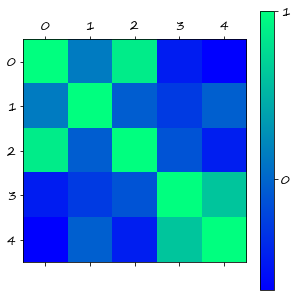

In [12]:
close_price = df1['close']
df1['price_change'] = np.log(close_price) - np.log(close_price.shift(1))
df1['price_change'].fillna(method='bfill', inplace=True) # replace Nan with the data after it 
#print(df1['price_change'].count())
df1['v20d'] = df1['volume'].rolling(20,min_periods = 1).mean()
index = df1[['close', 'price_change', 'c20d','volume', 'v20d']]
cov = np.corrcoef(index.T)
print(cov)

img = plt.matshow(cov,cmap=plt.cm.winter)
plt.colorbar(img, ticks=[-1,0,1])
plt.show()
#df1.head()

移動平均線策略-最簡單的方式就是：當5日均線從下方超越20日均線時，買入股票，當5日均線從上方越到20日均線之下時，賣出股票。  

-1    649
 1    334
 0     21
Name: signal, dtype: int64

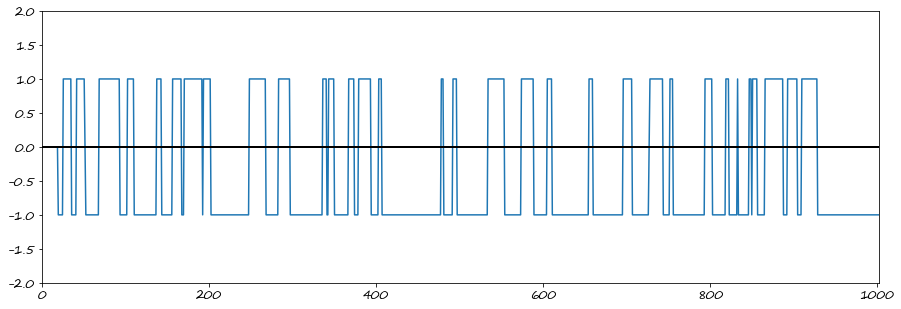

In [13]:
df['5d'] = np.round(df['close'].rolling(window = 5, center = False).mean(), 2)
df['20d'] = np.round(df['close'].rolling(window = 20, center = False).mean(), 2)
 
df['20d-5d'] = df['20d'] - df['5d']
df.tail()
# np.where() is a vectorized if-else function, where a condition is checked for each component of a vector, and the first argument passed is used when the condition holds, and the other passed if it does not
df['signal'] = np.where(df['20d-5d'] > 0, 1, 0)
# We have 1's for bullish regimes and 0's for everything else. Below I replace bearish regimes's values with -1, and to maintain the rest of the vector, the second argument is apple["Regime"]
df['signal'] = np.where(df['20d-5d'] < 0, -1, df['signal'])
#df.loc['2018-05-01':'2019-04-25',"Regime"].plot(ylim = (-2,2)).axhline(y = 0, color = "black", lw = 2)
df['signal'].plot(ylim = (-2,2)).axhline(y = 0, color = "black", lw = 2)
df['signal'].value_counts()

In [14]:
trade = pd.concat([

pd.DataFrame({"price": df.loc[df["signal"] == 1, "close"],"operation": "Buy"}),

pd.DataFrame({"price": df.loc[df["signal"] == -1, "close"],"operation": "Sell"})
])
trade.sort_index(inplace=True)
trade['signal'] = df['signal']
trade

,price,operation,signal
19,105.9291,Sell,-1
20,106.2852,Sell,-1
21,105.9483,Sell,-1
22,106.2660,Sell,-1
23,105.4574,Sell,-1
24,105.2072,Sell,-1
25,104.1387,Buy,1
26,103.9655,Buy,1
27,105.3900,Buy,1
28,105.5441,Buy,1


C:\Users\Elvish\anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning:

invalid value encountered in sign



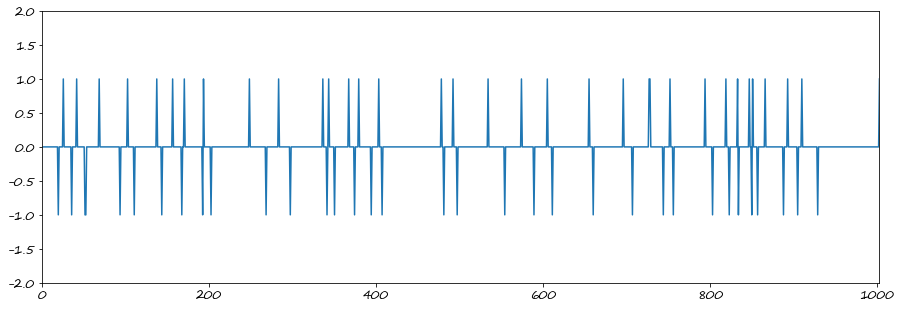

In [16]:
# To ensure that all trades close out, I temporarily change the signal of the last row to 0
signal_orig = df.loc[:, "signal"].iloc[-1]
df.loc[:, "signal"].iloc[-1] = 0
df["Signal"] = np.sign(df["signal"] - df["signal"].shift(1))
# Restore original regime data
df.loc[:, "signal"].iloc[-1] = signal_orig
df.tail()
df["Signal"].plot(ylim = (-2, 2))

In [17]:
df["Signal"].value_counts()
df.loc[df["Signal"] == 1, "close"]

25      104.1387
41      103.2978
68      106.4237
102      99.5356
137     106.2281
156     107.1468
170     106.2230
193      95.1836
248     105.5163
283     104.8061
336     113.7086
343     111.4844
367     114.4237
379     114.4139
403     114.0325
478     128.3980
492     128.1719
534     137.3622
574     138.9984
605     141.0513
655     150.9388
696     156.5108
727     165.4889
728     161.4042
752     160.6012
794     170.9602
819     175.9777
833     179.1968
847     181.9390
851     180.1705
866     178.2151
893     164.4297
910     162.8471
1003    190.6500
Name: close, dtype: float64

In [18]:
# Create a DataFrame with trades, including the price at the trade and the regime under which the trade is made.
qqq_signals = pd.concat([
        pd.DataFrame({"Price": df.loc[df["Signal"] == 1, "close"],
                     "Regime": df.loc[df["Signal"] == 1, "Signal"],
                     "Signal": "Buy"}),
        pd.DataFrame({"Price": df.loc[df["Signal"] == -1, "close"],
                     "Regime": df.loc[df["Signal"] == -1, "Signal"],
                     "Signal": "Sell"}),
    ])
qqq_signals.sort_index(inplace = True)
qqq_signals

,Price,Regime,Signal
19,105.9291,-1.0,Sell
25,104.1387,1.0,Buy
35,106.8000,-1.0,Sell
41,103.2978,1.0,Buy
51,106.4912,-1.0,Sell
52,107.9963,-1.0,Sell
68,106.4237,1.0,Buy
93,101.5420,-1.0,Sell
102,99.5356,1.0,Buy
110,102.1565,-1.0,Sell


In [19]:
# Let's see the profitability of long trades
long_profits = pd.DataFrame({
    
        "End Date": trade["price"].loc[
            trade[(trade["operation"].shift(1) == "Buy") & (trade["signal"].shift(1) == 1)].index
        ].index,        
        'Price': trade.loc[(trade['operation'] == 'Buy') &
                                  trade['signal'] == 1, 'price'],
        "Profit": pd.Series(trade["price"] - trade["price"].shift(1)).loc[
            trade.loc[(trade["operation"].shift(1) == "Buy") & (trade["signal"].shift(1) == 1)].index
        ].tolist()
    })
print(long_profits)
print(long_profits['Profit'].mean())

     End Date     Price  Profit
25         26  104.1387 -0.1732
26         27  103.9655  1.4245
27         28  105.3900  0.1541
28         29  105.5441 -0.8663
29         30  104.6778 -0.5198
30         31  104.1580  0.5679
31         32  104.7259  0.2888
32         33  105.0147  1.5304
33         34  106.5451 -0.5266
34         35  106.0185  0.7815
41         42  103.2978  0.8201
42         43  104.1179  0.0289
43         44  104.1468 -0.2412
44         45  103.9056  0.2605
45         46  104.1661 -1.8137
46         47  102.3524 -0.0579
47         48  102.2945  1.5629
48         49  103.8574  1.8234
49         50  105.6808  0.6947
50         52  106.3755  1.6208
68         69  106.4237  1.2156
69         70  107.6393 -1.3796
70         71  106.2597  0.3666
71         72  106.6263 -0.1737
72         73  106.4526  0.1640
73         74  106.6166  0.8876
74         75  107.5042 -0.5499
75         76  106.9543 -0.7043
76         77  106.2500 -2.9425
77         78  103.3075 -4.5151
..      

[修復mpl問題](https://www.jianshu.com/p/c10e57ccc7ba)  

In [20]:
import pandas_datareader.data as wb
stocklist = ['QQQ','XLK','VGT','IYW','SPY']

start = datetime(2014,5,1)
end = datetime(2019,4,22)

all_etf = wb.DataReader(stocklist, 'iex', start, end)
all_etf.to_csv("multdata.csv".format(symbol),na_rep='NA') # multiple etf data
all_etf.head()

Attributes     open                                          high           \
Symbols         IYW      QQQ       SPY      VGT      XLK      IYW      QQQ   
date                                                                         
2014-05-07  85.2044  82.8200  169.7541  84.3403  33.3299  85.2992  82.8962   
2014-05-08  84.5791  82.1156  169.9715  83.7590  33.2103  85.7255  83.3246   
2014-05-09  84.7118  82.2584  169.9896  83.8715  33.3575  85.0055  82.6868   
2014-05-12  85.3844  83.1152  170.9587  84.5278  33.5783  86.5024  84.0195   
2014-05-13  86.6161  84.0766  172.1089  85.6155  33.9187  86.8340  84.3527   

Attributes                              ...    close                     \
Symbols          SPY      VGT      XLK  ...      IYW      QQQ       SPY   
date                                    ...                               
2014-05-07  170.2432  84.3684  33.3759  ...  84.7781  82.4012  170.1617   
2014-05-08  171.2213  84.9685  33.6795  ...  84.7781  82.3250  169.9760   
2014-05-09  170.3066  84.1621  33.4403  ...  84.9581  82.6297  170.2341   
2014-05-12  171.9730  85.6333  33.8911  ...  86.4077  83.9910  171.8870   
2014-05-13  172.4621  85.9512  33.9831  ...  86.4456  84.0481  172.0455   

Attributes                    volume                                        
Symbols         VGT      XLK     IYW       QQQ        SPY     VGT      XLK  
date                                                                        
2014-05-07  83.8996  33.2931  179187  67489143  106500480  475394  6827022  
2014-05-08  83.9371  33.3851  209833  46556871   93617513  372874  3787427  
2014-05-09  84.1340  33.4219  170888  35081529   83678568  224153  7438540  
2014-05-12  85.5405  33.8727  133018  38951060   86940045  226070  5593376  
2014-05-13  85.5217  33.8911  136048  30311862   66453965  222823  5744088  

[5 rows x 25 columns]

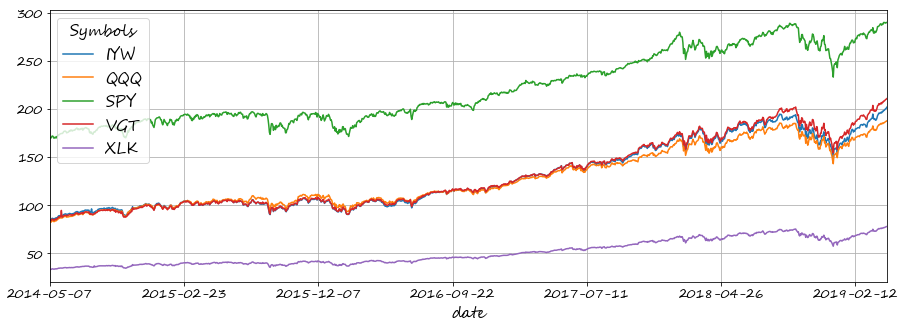

In [21]:
all_etf['close'].plot(grid=True)

絕對價格固然重要，然而交易時真正在乎的是價格的相對變動量，由於有價格高低之差異，為了更清楚看出價格損益，將其先作分類重新畫圖  

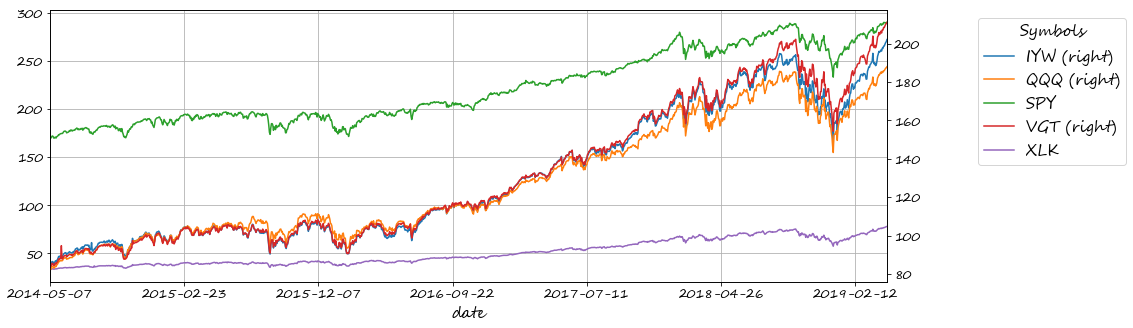

In [30]:
ax = all_etf['close'].plot(secondary_y = ['IYW','VGT','QQQ'],grid=True)
ax.get_legend().set_bbox_to_anchor((1.1, 1)) #set the legend position

計算報酬率  

In [31]:
# df.apply(arg) will apply the function arg to each column in df, and return a DataFrame with the result
# Recall that lambda x is an anonymous function accepting parameter x; in this case, x will be a pandas Series object
stock_return = all_etf.apply(lambda x: x / x[0])
stock_return.head() - 1

Attributes      open                                              high  \
Symbols          IYW       QQQ       SPY       VGT       XLK       IYW   
date                                                                     
2014-05-07  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2014-05-08 -0.007339 -0.008505  0.001281 -0.006892 -0.003588  0.004998   
2014-05-09 -0.005781 -0.006781  0.001387 -0.005558  0.000828 -0.003443   
2014-05-12  0.002113  0.003564  0.007096  0.002223  0.007453  0.014106   
2014-05-13  0.016568  0.015173  0.013872  0.015120  0.017666  0.017993   

Attributes                                          ...     close            \
Symbols          QQQ       SPY       VGT       XLK  ...       IYW       QQQ   
date                                                ...                       
2014-05-07  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
2014-05-08  0.005168  0.005745  0.007113  0.009096  ...  0.000000 -0.000925   
2014-05-09 -0.002526  0.000372 -0.002445  0.001930  ...  0.002123  0.002773   
2014-05-12  0.013551  0.010161  0.014993  0.015436  ...  0.019222  0.019293   
2014-05-13  0.017570  0.013034  0.018761  0.018193  ...  0.019669  0.019986   

Attributes                                  volume                      \
Symbols          SPY       VGT       XLK       IYW       QQQ       SPY   
date                                                                     
2014-05-07  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2014-05-08 -0.001091  0.000447  0.002763  0.171028 -0.310158 -0.120966   
2014-05-09  0.000425  0.002794  0.003869 -0.046315 -0.480190 -0.214289   
2014-05-12  0.010139  0.019558  0.017409 -0.257658 -0.422854 -0.183665   
2014-05-13  0.011071  0.019334  0.017962 -0.240748 -0.550863 -0.376022   

Attributes                      
Symbols          VGT       XLK  
date                            
2014-05-07  0.000000  0.000000  
2014-05-08 -0.215653 -0.445230  
2014-05-09 -0.528490  0.089573  
2014-05-12 -0.524458 -0.180700  
2014-05-13 -0.531288 -0.158625  

[5 rows x 25 columns]

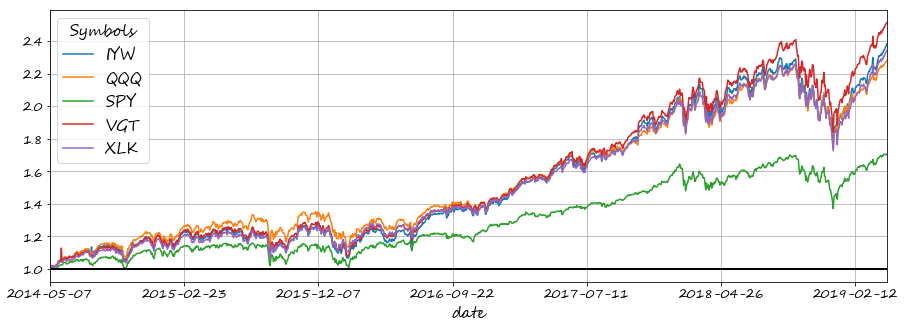

In [32]:
stock_return['close'].plot(grid = True).axhline(y = 1, color = "black", lw = 2)

計算價格對數之差

In [33]:
stock_change = all_etf.apply(lambda x: np.log(x) - np.log(x.shift(1))) # shift moves dates back by 1.
stock_change.head()

Attributes      open                                              high  \
Symbols          IYW       QQQ       SPY       VGT       XLK       IYW   
date                                                                     
2014-05-07       NaN       NaN       NaN       NaN       NaN       NaN   
2014-05-08 -0.007366 -0.008542  0.001280 -0.006916 -0.003595  0.004985   
2014-05-09  0.001568  0.001738  0.000106  0.001342  0.004423 -0.008434   
2014-05-12  0.007909  0.010362  0.005685  0.007795  0.006597  0.017456   
2014-05-13  0.014322  0.011501  0.006705  0.012786  0.010086  0.003826   

Attributes                                          ...     close            \
Symbols          QQQ       SPY       VGT       XLK  ...       IYW       QQQ   
date                                                ...                       
2014-05-07       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2014-05-08  0.005155  0.005729  0.007088  0.009055  ...  0.000000 -0.000925   
2014-05-09 -0.007684 -0.005357 -0.009536 -0.007128  ...  0.002121  0.003694   
2014-05-12  0.015989  0.009737  0.017330  0.013391  ...  0.016919  0.016340   
2014-05-13  0.003958  0.002840  0.003705  0.002711  ...  0.000439  0.000680   

Attributes                                  volume                      \
Symbols          SPY       VGT       XLK       IYW       QQQ       SPY   
date                                                                     
2014-05-07       NaN       NaN       NaN       NaN       NaN       NaN   
2014-05-08 -0.001092  0.000447  0.002760  0.157882 -0.371292 -0.128932   
2014-05-09  0.001517  0.002343  0.001102 -0.205304 -0.283000 -0.112235   
2014-05-12  0.009663  0.016579  0.013398 -0.250524  0.104631  0.038236   
2014-05-13  0.000922 -0.000220  0.000543  0.022523 -0.250767 -0.268709   

Attributes                      
Symbols          VGT       XLK  
date                            
2014-05-07       NaN       NaN  
2014-05-08 -0.242903 -0.589202  
2014-05-09 -0.508912  0.674988  
2014-05-12  0.008516 -0.285092  
2014-05-13 -0.014467  0.026588  

[5 rows x 25 columns]

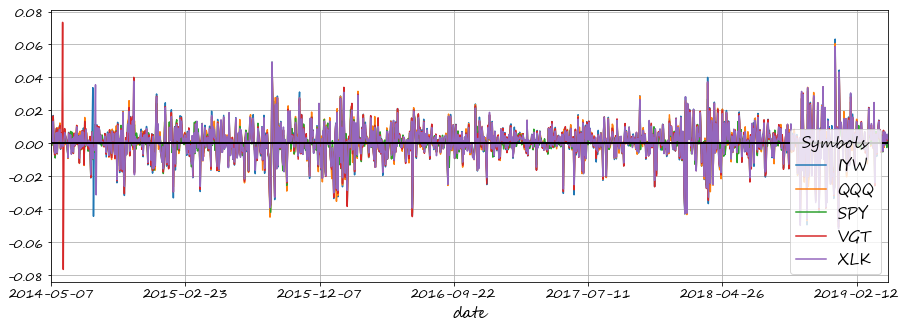

In [34]:
stock_change['close'].plot(grid = True).axhline(y = 0, color = "black", lw = 2)

問題  
> [kernel相關問題](https://stackoverflow.com/questions/39604271/conda-environments-not-showing-up-in-jupyter-notebook?rq=1)  

